# Bengali AI - Image Processing

WIP: This notebook demonstrates how to:
- read image data from a parquet file via a batch generator function
- transform_X(): cast, normalize, reshape, resize, denoise 
- TODO: center and crop (have forum function)
- TODO: ImageDataGenerator subclass with custom .flow_from_generator() 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import glob2
import gc
import pyarrow
import time
import math
import skimage
import skimage.measure
import skimage.filters
import scipy
from timeit import timeit
from time import sleep
from pyarrow.parquet import ParquetFile
from typing import Callable
from pandas import DataFrame


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from itertools import chain
from functools import reduce

pd.set_option('display.max_columns',   500)
pd.set_option('display.max_colwidth',   -1)

In [2]:
def plt_imshow_batch( batch_X, cols=8, cmap='gray' ):
    imgs = (batch_X.squeeze() * 255).astype('uint8')
    rows = math.ceil(len(imgs)/cols)
        
    fig, ax = plt.subplots(figsize=(20, rows*2))    
    plt.axis('off')        
    for index, img in enumerate(imgs):
        plt.subplot(rows, cols, index+1)
        plt.imshow(img, cmap=cmap)    

In [3]:
# Source: https://www.kaggle.com/jamesmcguigan/reading-parquet-files-ram-cpu-optimization/
def parquet_batch_generator(batch_size=128, reads_per_file=2):
    filenames = sorted(glob2.glob('../input/bengaliai-cv19/train_image_data_*.parquet')); filenames    
    for filename in filenames:
        num_rows    = ParquetFile(filename).metadata.num_rows
        cache_size  = math.ceil( num_rows / batch_size / reads_per_file ) * batch_size
        batch_count = math.ceil( cache_size / batch_size )
        for n_read in range(reads_per_file):
            cache = pd.read_parquet(filename).iloc[ cache_size * n_read : cache_size * (n_read+1) ].copy()
            gc.collect(); sleep(1);  # sleep(1) is required to allow measurement of the garbage collector
            for n_batch in range(batch_count):            
                yield cache[ batch_size * n_batch : batch_size * (n_batch+1) ].copy()

In [4]:
# Source: https://stackoverflow.com/a/31402351/748503
def bounding_box(img):
    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    return rmin, rmax, cmin, cmax, zmin, zmax    

In [5]:
# Source: https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy

# This is the fast method that simply remove all empty rows/columns
# NOTE: assumes inverted
def crop_image(img, tol=0):
    mask = img > tol
    return img[np.ix_(mask.any(1),mask.any(0))]


# DOCS: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
# NOTE: assumes inverted
def crop_center_image(img, tol=0):
    org_shape   = img.shape
    img_cropped = crop_image(img)
    pad_x       = (org_shape[0] - img_cropped.shape[0])/2
    pad_y       = (org_shape[1] - img_cropped.shape[1])/2
    padding     = (
        (math.floor(pad_x), math.ceil(pad_x)),
        (math.floor(pad_y), math.ceil(pad_y))
    )
    img_center = np.pad(img_cropped, padding, 'constant', constant_values=0)
    return img_center


# Source: https://www.kaggle.com/jamesmcguigan/bengali-ai-image-processing/
# noinspection PyArgumentList
def transform_X(train: DataFrame, denoise=True, normalize=True, center=True, invert=True, resize=2, resize_fn=None) -> np.ndarray:
    train = (train.drop(columns='image_id', errors='ignore')
             .values.astype('uint8')                   # unit8 for initial data processing
             .reshape(-1, 137, 236)                    # 2D arrays for inline image processing
    )
    gc.collect(); sleep(1)

    # Invert for processing
    # Colors   |   0 = black      | 255 = white
    # invert   |   0 = background | 255 = line
    # original | 255 = background |   0 = line
    train = (255-train)
    
    if denoise:                     
        # Rescale lines to maximum brightness, and set background values (less than 2x mean()) to 0
        train = np.array([ train[i] + (255-train[i].max())              for i in range(train.shape[0]) ])        
        train = np.array([ train[i] * (train[i] >= np.mean(train[i])*2) for i in range(train.shape[0]) ])                                  
            
    if isinstance(resize, bool) and resize == True:
        resize = 2    # Reduce image size by 2x
    if resize and resize != 1:                  
        # NOTEBOOK: https://www.kaggle.com/jamesmcguigan/bengali-ai-image-processing/
        # Out of the different resize functions:
        # - np.mean(dtype=uint8) produces produces fragmented images (needs float16 to work properly - but RAM intensive)
        # - np.median() produces the most accurate downsampling
        # - np.max() produces an enhanced image with thicker lines (maybe slightly easier to read)
        # - np.min() produces a  dehanced image with thiner lines (harder to read)
        resize_fn = resize_fn or (np.max if invert else np.min)
        cval      = 0 if invert else 255
        train = skimage.measure.block_reduce(train, (1, resize,resize), cval=cval, func=resize_fn)
            
    if center:
        # NOTE: crop_center_image() assumes inverted
        train = np.array([
            crop_center_image(train[i,:,:])
            for i in range(train.shape[0])
        ])
        
    # Un-invert if invert==False
    if not invert: train = (255-train)

    if normalize:
        train = train.astype('float16') / 255.0   # prevent division cast: int -> float64

    train = train.reshape(*train.shape, 1)        # 4D ndarray for tensorflow CNN

    gc.collect(); sleep(1)
    return train

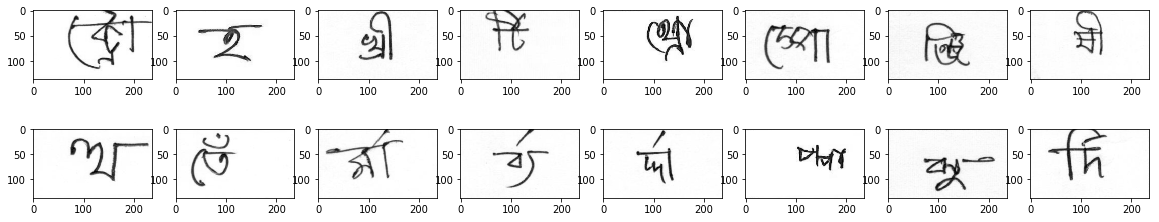

In [6]:
# Without preprocessing
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=False, center=False, invert=False, resize=False)
    plt_imshow_batch(batch_X)
    break

In [ ]:
# Denoise
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=False, center=False, resize=False)
    plt_imshow_batch(batch_X)
    break

In [ ]:
# Denoise + Invert
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=False,  resize=False)
    plt_imshow_batch(batch_X)
    break

In [ ]:
# Denoise + Invert + Center
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True,  resize=False)
    plt_imshow_batch(batch_X, cols=4)
    break

Out of the different resize functions:
- np.mean(dtype=uint8) produces distored results (needs float16 to work properly - but RAM intensive)
- np.median() produces the most accurate downsampling
- np.max() produces an enhanced image with thicker lines (maybe slightly easier to read)
- np.min() produces a  dehanced image with thiner lines (harder to read)

In [ ]:
# Denoise + Center + Resize Default (without Invert)
mean = lambda x, axis: np.mean(x, axis=axis, dtype=np.uint8)  # func_kwargs={} arg not in pip version    
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=False, center=True, resize=2)
    plt_imshow_batch(batch_X, cols=8)
    break

In [ ]:
# Denoise + Invert + Center + Resize Mean uint8
mean = lambda x, axis: np.mean(x, axis=axis, dtype=np.uint8)  # func_kwargs={} arg not in pip version    
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2, resize_fn=mean)
    plt_imshow_batch(batch_X, cols=8)
    break

In [ ]:
# Denoise + Invert + Center + Resize Median
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2, resize_fn=np.median)
    plt_imshow_batch(batch_X, cols=8)
    break

In [ ]:
# Denoise + Invert + Center + Resize Median
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2)
    plt_imshow_batch(batch_X, cols=8)
    break

In [ ]:
# Denoise + Invert + Center + Resize Max
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2, resize_fn=np.max)
    plt_imshow_batch(batch_X, cols=8)
    break

In [ ]:
# Denoise + Invert + Center + Resize Min
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2, resize_fn=np.min)
    plt_imshow_batch(batch_X, cols=8)
    break

# ImageDataGenerator

In [ ]:
for train_batch in parquet_batch_generator(8):
    train_batch = transform_X( train_batch, normalize=False )  # ImageDataGenerator(rescale=1./255) saves float16 conversion
    break
( train_batch.dtype, train_batch.shape )

In [ ]:
# DOCS: https://keras.io/preprocessing/image/#imagedatagenerator-class
time_start = time.time()
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     featurewise_center=True,             # No visible effect in plt.imgshow() 
#     samplewise_center=True,              # No visible effect in plt.imgshow()
#     featurewise_std_normalization=True,  # No visible effect in plt.imgshow() | requires .fit()
#     samplewise_std_normalization=True,   # No visible effect in plt.imgshow() | requires .fit()
#     zca_whitening=True,                   # Kaggle, insufficent memory

    zoom_range=0.2,
    rotation_range=45/2,
    shear_range=45/2,
    width_shift_range=0.1,    # we already have centering
    height_shift_range=0.1,   # we already have centering
    brightness_range=(0.5,2),
    fill_mode='constant',
    cval=0,        
)
train_datagen.fit( train_batch )
print('time: datagen.fit()', time.time() - time_start)

train_generator = train_datagen.flow(
    train_batch,
    subset="training",
    shuffle=False,  
    batch_size=32,  # cant be larger than train_batch
)
gc.collect()

count = 0
for datagen_batch in train_generator:
    plt_imshow_batch(datagen_batch, cols=8)
    count += datagen_batch.shape[0]
    if count >= 8*8: break
        
print('time: datagen.fit() + flow()', time.time() - time_start)        

Note that ZCA is very slow, and only ever seems to produce a single image

In [ ]:
time_start = time.time()
zca_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,             # No visible effect in plt.imgshow() 
    samplewise_center=True,              # No visible effect in plt.imgshow()    
    zca_whitening=True, # Kaggle, insufficent memory
)
zca_datagen.fit( train_batch )
print('time: zca.fit()', time.time() - time_start)

zca_generator = zca_datagen.flow(
    train_batch,
    subset="training",
    shuffle=False,  
    batch_size=8,  # cant be larger than train_batch
)
count = 0
for datagen_batch in zca_generator:
    plt_imshow_batch(datagen_batch, cols=8)
    count += datagen_batch.shape[0]
    if count >= 8*8: break
        
print('time: zca.fix() + flow()', time.time() - time_start)        

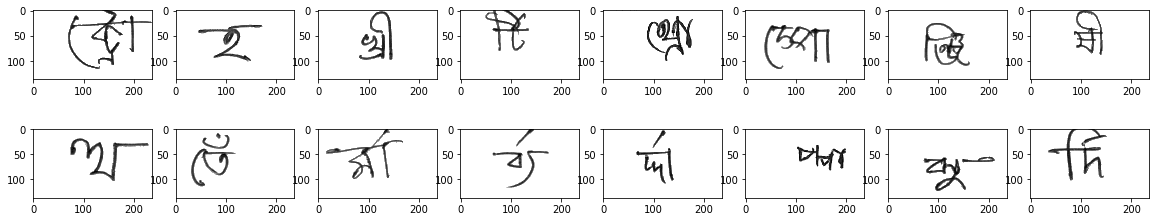

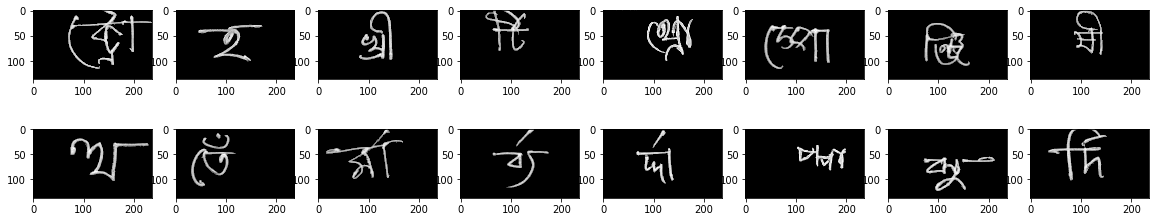

In [8]:
# Denoise + Invert
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=False,  resize=False)
    plt_imshow_batch(batch_X)
    break

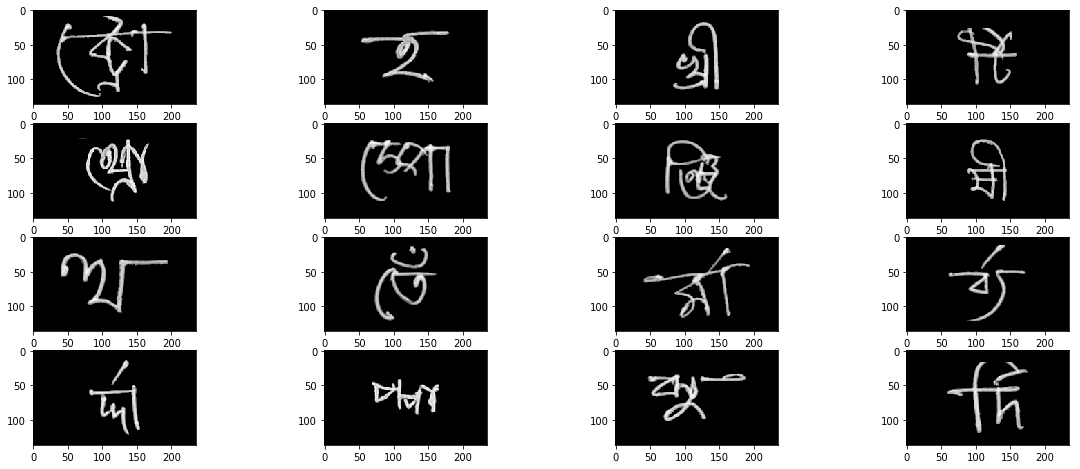

In [9]:
# Denoise + Invert + Center
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True,  resize=False)
    plt_imshow_batch(batch_X, cols=4)
    break

Out of the different resize functions:
- np.mean(dtype=uint8) produces distored results (needs float16 to work properly - but RAM intensive)
- np.median() produces the most accurate downsampling
- np.max() produces an enhanced image with thicker lines (maybe slightly easier to read)
- np.min() produces a  dehanced image with thiner lines (harder to read)

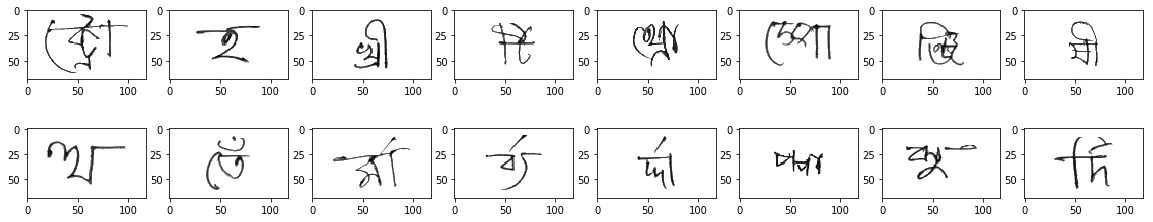

In [10]:
# Denoise + Center + Resize Default (without Invert)
mean = lambda x, axis: np.mean(x, axis=axis, dtype=np.uint8)  # func_kwargs={} arg not in pip version    
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=False, center=True, resize=2)
    plt_imshow_batch(batch_X, cols=8)
    break

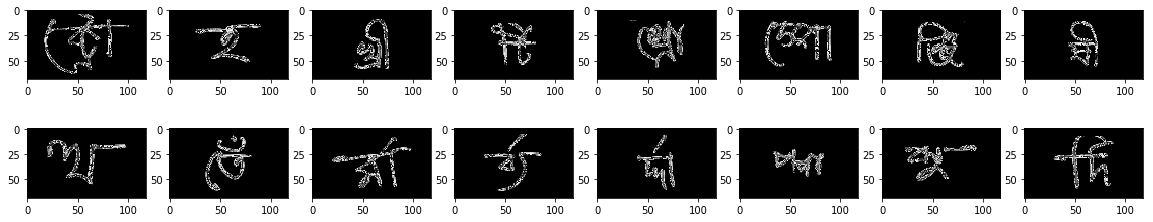

In [11]:
# Denoise + Invert + Center + Resize Mean uint8
mean = lambda x, axis: np.mean(x, axis=axis, dtype=np.uint8)  # func_kwargs={} arg not in pip version    
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2, resize_fn=mean)
    plt_imshow_batch(batch_X, cols=8)
    break

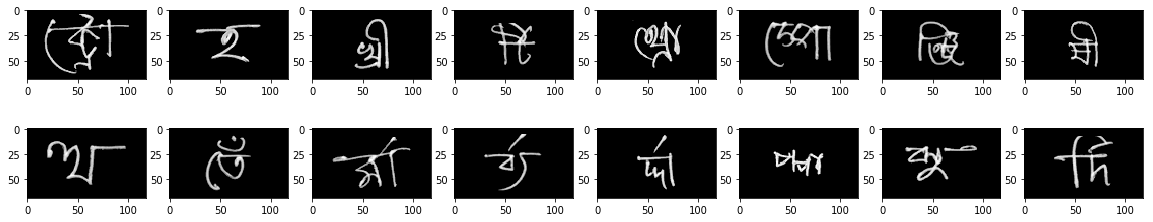

In [12]:
# Denoise + Invert + Center + Resize Median
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2, resize_fn=np.median)
    plt_imshow_batch(batch_X, cols=8)
    break

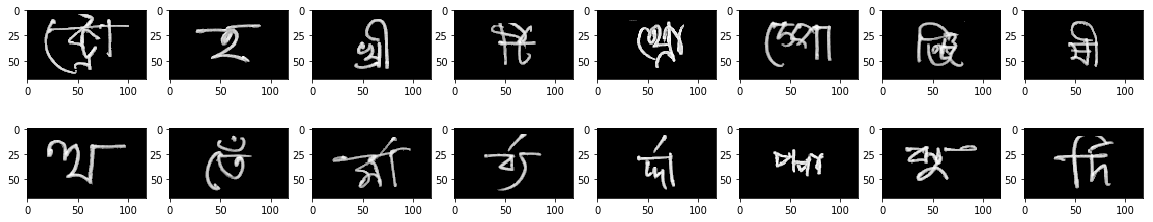

In [13]:
# Denoise + Invert + Center + Resize Median
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2)
    plt_imshow_batch(batch_X, cols=8)
    break

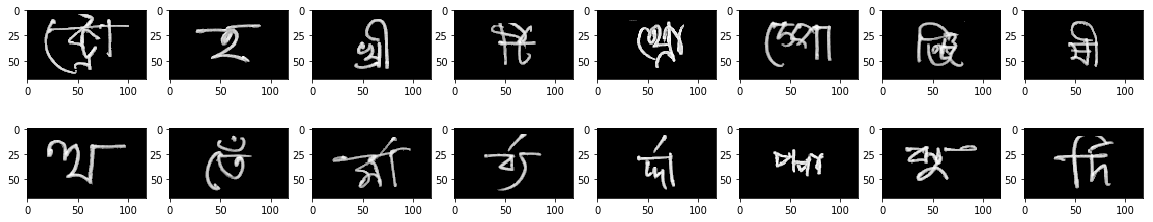

In [14]:
# Denoise + Invert + Center + Resize Max
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2, resize_fn=np.max)
    plt_imshow_batch(batch_X, cols=8)
    break

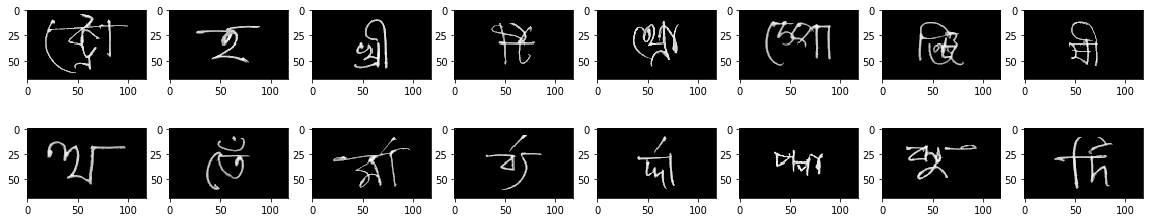

In [15]:
# Denoise + Invert + Center + Resize Min
for batch_raw in parquet_batch_generator(16):
    batch_X = transform_X(batch_raw, denoise=True, invert=True, center=True, resize=2, resize_fn=np.min)
    plt_imshow_batch(batch_X, cols=8)
    break

# ImageDataGenerator

In [16]:
for train_batch in parquet_batch_generator(8):
    train_batch = transform_X( train_batch, normalize=False )  # ImageDataGenerator(rescale=1./255) saves float16 conversion
    break
( train_batch.dtype, train_batch.shape )

(dtype('uint8'), (8, 69, 118, 1))

time: datagen.fit() 0.0008380413055419922
time: datagen.fit() + flow() 1.181511640548706


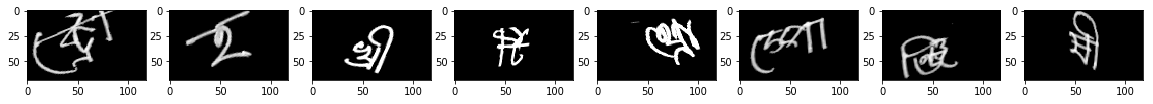

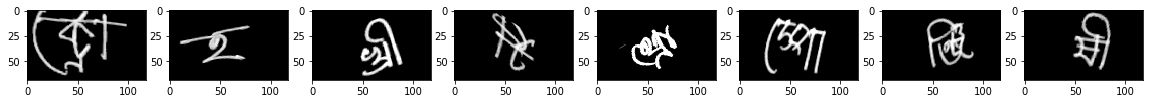

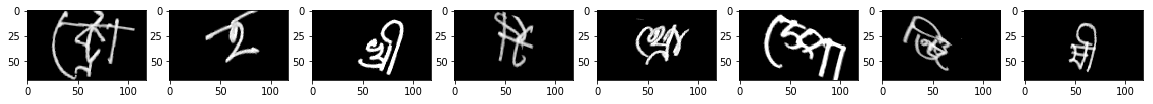

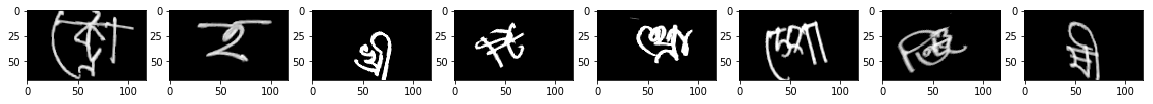

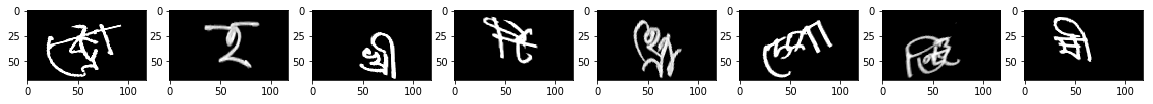

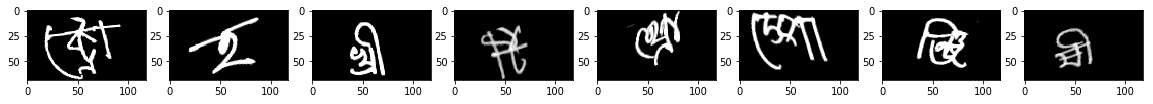

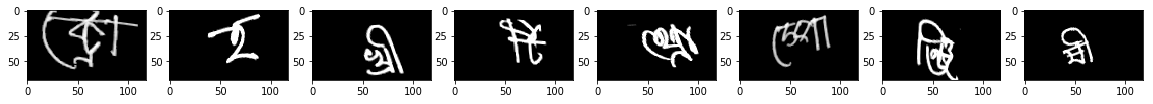

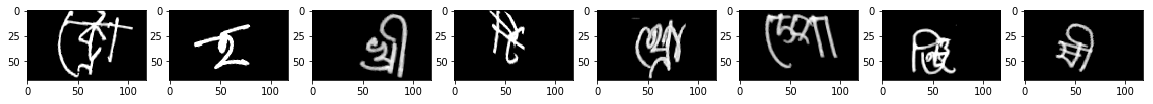

In [17]:
# DOCS: https://keras.io/preprocessing/image/#imagedatagenerator-class
time_start = time.time()
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     featurewise_center=True,             # No visible effect in plt.imgshow() 
#     samplewise_center=True,              # No visible effect in plt.imgshow()
#     featurewise_std_normalization=True,  # No visible effect in plt.imgshow() | requires .fit()
#     samplewise_std_normalization=True,   # No visible effect in plt.imgshow() | requires .fit()
#     zca_whitening=True,                   # Kaggle, insufficent memory

    zoom_range=0.2,
    rotation_range=45/2,
    shear_range=45/2,
    width_shift_range=0.1,    # we already have centering
    height_shift_range=0.1,   # we already have centering
    brightness_range=(0.5,2),
    fill_mode='constant',
    cval=0,        
)
train_datagen.fit( train_batch )
print('time: datagen.fit()', time.time() - time_start)

train_generator = train_datagen.flow(
    train_batch,
    subset="training",
    shuffle=False,  
    batch_size=32,  # cant be larger than train_batch
)
gc.collect()

count = 0
for datagen_batch in train_generator:
    plt_imshow_batch(datagen_batch, cols=8)
    count += datagen_batch.shape[0]
    if count >= 8*8: break
        
print('time: datagen.fit() + flow()', time.time() - time_start)        

Note that ZCA is very slow, and only ever seems to produce a single image

time: zca.fit() 119.86765146255493
time: zca.fix() + flow() 122.21854186058044


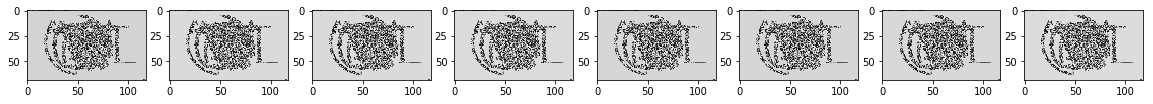

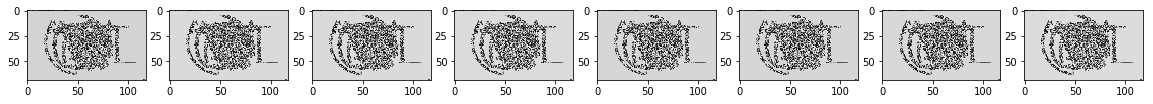

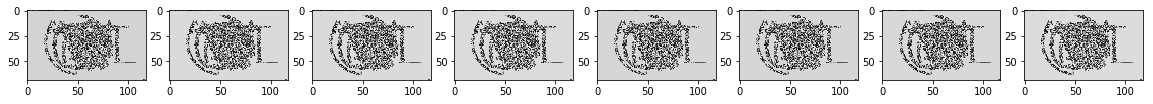

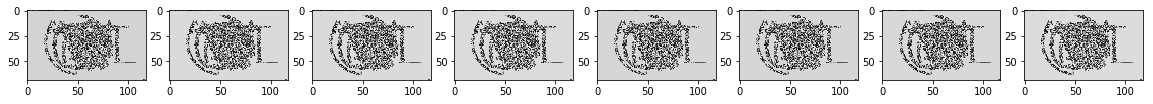

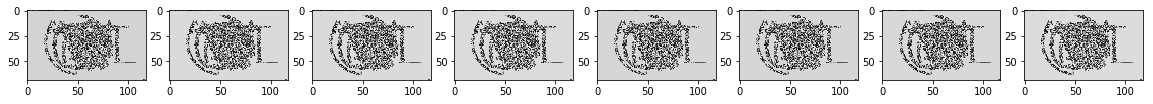

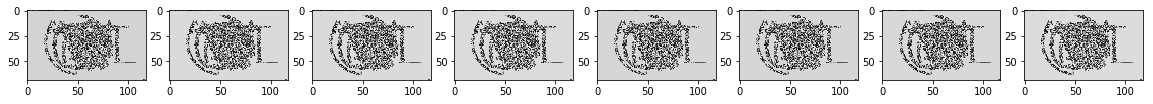

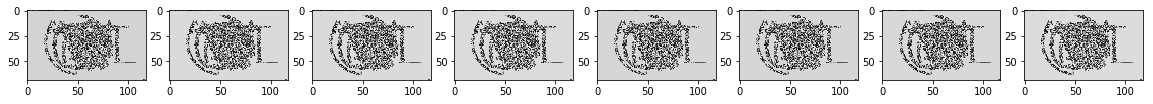

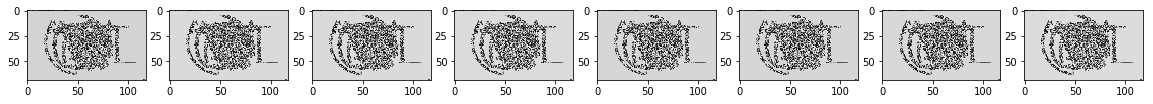

In [18]:
time_start = time.time()
zca_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,             # No visible effect in plt.imgshow() 
    samplewise_center=True,              # No visible effect in plt.imgshow()    
    zca_whitening=True, # Kaggle, insufficent memory
)
zca_datagen.fit( train_batch )
print('time: zca.fit()', time.time() - time_start)

zca_generator = zca_datagen.flow(
    train_batch,
    subset="training",
    shuffle=False,  
    batch_size=8,  # cant be larger than train_batch
)
count = 0
for datagen_batch in zca_generator:
    plt_imshow_batch(datagen_batch, cols=8)
    count += datagen_batch.shape[0]
    if count >= 8*8: break
        
print('time: zca.fix() + flow()', time.time() - time_start)        